In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import rpy2.robjects as robj
import pyreadr
%matplotlib inline
from easydict import EasyDict as edict
from tqdm import tqdm_notebook as tqdm
import sys
import time as Time
import pickle
from scipy.signal import detrend

In [2]:
sys.path.append("/home/huaqingj/MyResearch/TVDN")
from pyTVDN.TVDNutils import *
from pyTVDN import TVDNDetect

In [3]:
robj.r["load"]("/home/huaqingj/MyResearch/TVDN/data/datamatrix3chg6rank.Rdata")

'datamatrix','truematrix','candlist0','trueU'


In [41]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def TuningKappaNew(self, kappas):
        assert self.finalRes is not None, "Run main function first!"
        
        MaxM = self.paras.MaxM
        U0 = self.finalRes.U0 
        rAct, n = self.midRes.nXmat.shape
        r = self.paras.r
        Us = []
        for kappac in kappas:
            Us.append(U0 + 2*r*np.log(n)**kappac* (np.arange(1, MaxM+2)))
        Us = np.array(Us)
        numchgs = Us.argmin(axis=1)
        self.numchgs = numchgs
        argIdx = np.argmin(np.diff(numchgs)/np.diff(kappas))
        
        self.Us = Us
        mUs = Us.min(axis=1)
        argmU = np.argmin(mUs)
        
        chgsKappas = []
        for numchg in numchgs:
            chgsKappas.append(self.finalRes.chgMat[numchg-1, :numchg])
        
        res = edict()
        res.kp1 = kappas[argIdx+1]
        res.numChgs1 = numchgs[argIdx+1]
        res.cpts1 = self.finalRes.chgMat[res.numChgs1-1, :res.numChgs1] 
        res.kp2 = kappas[argmU]
        res.numChgs2 = numchgs[argmU]
        res.cpts2 = self.finalRes.chgMat[res.numChgs2-1, :res.numChgs2] 
        res.chgsKappas = chgsKappas
        
        return res

In [42]:
kappa = 1.53
lamb = 1e-6
r = 6 
Lmin = 4

In [37]:
Ymat = np.array(robj.r["datamatrix"][0])

In [39]:
simuDet = TVDNDetect1(Ymat=Ymat,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=0.5, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=r, kappa=kappa, freq=0.5, lamb=1e-8,
                          decimateRate=None, is_detrend=True)
simuDet()
kappas = np.arange(0.68, 4, 0.01)
res = simuDet.TuningKappaNew(kappas)

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': True,
 'kappa': 1.53,
 'lamb': 1e-08,
 'nbasis': 10,
 'r': 6}


### Simulation for first two methods

1. Method 1, maximize the $\frac{y_i - y_{i-1}}{\kappa_i - \kappa_{i-1}}$.

2. Method 2, minimize the MBIC. 

In fact, Method 2, is meaningless. Because fixed $\kappa$, the MBIC has smallest value at maximal number of change points.
And fixing the num of change points, the MBIC has smallest value at minimal $\kappa$. So Method 2 also yields maximal num of change points and minimal $\kappa$ (in my code, (20, 0.68)).

In [43]:
results1 = []
results2 = []
kappas = np.arange(0.68, 4, 0.01)
for i in tqdm(range(100)):
    Ymat = np.array(robj.r["datamatrix"][i])
    simuDet = TVDNDetect1(Ymat=Ymat,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=0.5, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=r, kappa=kappa, freq=0.5, lamb=1e-8, showProgress=False, 
                          decimateRate=None, is_detrend=True)
    simuDet()
    res = simuDet.TuningKappaNew(kappas)
    results1.append(res.cpts1)
    results2.append(res.cpts2)

### Plot the change points and the MBIC for first two methods

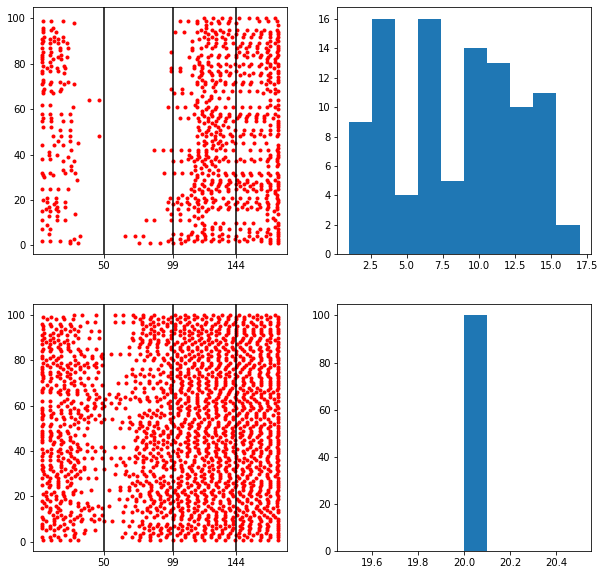

In [48]:
plt.figure(figsize=[10, 10])

plt.subplot(221)
simuIdx = []
pos = []
for idx, chgpts in enumerate(results1):
    pos += list(chgpts)
    simuIdx += ([idx+1]*len(chgpts))
plt.plot(pos, simuIdx, ".", color="red")
plt.xlim([0, 180])
plt.xticks([50, 99, 144], [50, 99, 144])
plt.axvline([50], color="black")
plt.axvline([99], color="black")
plt.axvline([144], color="black")

plt.subplot(222)
numchgs1 = [len(result) for result in results1]
plt.hist(numchgs1)

plt.subplot(223)
simuIdx = []
pos = []
for idx, chgpts in enumerate(results2):
    pos += list(chgpts)
    simuIdx += ([idx+1]*len(chgpts))
plt.plot(pos, simuIdx, ".", color="red")
plt.xlim([0, 180])
plt.xticks([50, 99, 144], [50, 99, 144])
plt.axvline([50], color="black")
plt.axvline([99], color="black")
plt.axvline([144], color="black")

plt.subplot(224)
numchgs2 = [len(result) for result in results2]
_ = plt.hist(numchgs2)

### Method 3

1. Subsample from Ymat for 10 times
2. Detection and get the estimated change point set
3. For each $\kappa$, obtain the hausdorff distance pairwise.
4. Find the mean and variance of h-distances for each $\kappa$.

In [97]:
Ymat = np.array(robj.r["datamatrix"][11])

In [98]:
result = []
for cvId in tqdm(range(10)):
    delIdx = np.arange(0, 180, 10) + cvId
    YmatNew = np.delete(Ymat, delIdx, axis=1)
    simuDet = TVDNDetect1(Ymat=YmatNew,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=0.5, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=r, kappa=kappa, freq=0.5, lamb=1e-8, showProgress=False, 
                          decimateRate=None, is_detrend=True)
    simuDet()
    res = simuDet.TuningKappaNew(kappas)
    adjChgsKps = [(chgsKappa*10/9).astype(np.int) for chgsKappa in res.chgsKappas]
    result.append(adjChgsKps)

In [99]:
from scipy.spatial.distance import directed_hausdorff
def Hdist(set1, set2):
    set1 = np.array(set1).reshape(-1, 1)
    set2 = np.array(set2).reshape(-1, 1)
    d1 = directed_hausdorff(set1, set2)[0]
    d2 = directed_hausdorff(set2, set1)[0]
    return np.max((d1, d2))

In [105]:
hdistss = []
for i in range(len(result[0])):
    hdists = []
    for j in range(10):
        for k in range(j+1, 10):
            hdists.append(Hdist(result[j][i], result[k][i]))
    hdistss.append(hdists)

In [106]:
hdistss = np.array(hdistss)

In [109]:
mhdists = hdistss.mean(axis=1)
vhdists = hdistss.var(axis=1)

Method 3 can't obtain meaningful results. Because, the H-distance has minimal mean and variance at maximal penalty, i.e. when the num of change point is $0$ at each subsample of Ymat.

Text(0, 0.5, 'Variance of hausdorff distances')

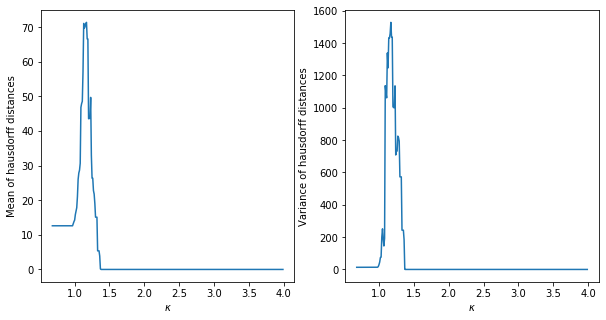

In [112]:
plt.figure(figsize=[10, 5])

plt.subplot(121)
plt.plot(kappas, mhdists)
plt.xlabel(r"$\kappa$")
plt.ylabel("Mean of hausdorff distances")

plt.subplot(122)
plt.plot(kappas, vhdists)
plt.xlabel(r"$\kappa$")
plt.ylabel("Variance of hausdorff distances")